In [18]:
import cv2
import numpy as np
import time
import os
from IPython.display import display, Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt

## Détection de couleur sous espace HSV

- HSV : facilite l'isolement de couleurs spécifiques, indépendamment de la luminosité et de l'intensité de la couleur.

- Utilisation d'un masque binaire pour la détection de couleurs dans un intervalle donné

- Traitement du masque pour réduire le buit (érosion,dilatation)

- Détection de la forme pour vérifier la forme (cerlce ou rectangulaire)

#### Masques

In [ ]:
def get_red_mask(hsv_img):
    
    
    # [Hue,Saturation,Brightness]
    
    #Le rouge se répète à 0° et 180°
    
    # Première plage pour couvrir autour de 0° 
    lower_red1 = np.array([0, 50, 50])    #  rouges plus foncés 
    upper_red1 = np.array([10, 255, 255]) #  rouges plus vifs
        
    # Deuxième plage pour couvrir autour de 180° 
    lower_red2 = np.array([170, 50, 50])  
    upper_red2 = np.array([180, 255, 255])
        
    lower_dark_red = np.array([0, 100, 30])
    upper_dark_red = np.array([10, 255, 150])

    
    lower_dark_red2 = np.array([170, 100, 30])
    upper_dark_red2 = np.array([180, 255, 150])
        
    # Rose
    lower_pink = np.array([0, 50, 150])   # teinte rouge avec une saturation plus basse
    upper_pink = np.array([10, 150, 255]) # valeur plus élevée pour le rose

    mask_red1 = cv2.inRange(hsv_img, lower_red1, upper_red1)      
    mask_red2 = cv2.inRange(hsv_img, lower_red2, upper_red2)     
    mask_dark_red1 = cv2.inRange(hsv_img, lower_dark_red, upper_dark_red)     
    mask_dark_red2 = cv2.inRange(hsv_img, lower_dark_red2, upper_dark_red2)    
    mask_pink = cv2.inRange(hsv_img, lower_pink, upper_pink)      

    # Combiner tous les masques de rouge, rouge foncé, et rose
    mask_combined_red = cv2.bitwise_or(mask_red1, mask_red2)
    mask_combined_red = cv2.bitwise_or(mask_combined_red, mask_dark_red1)
    mask_combined_red = cv2.bitwise_or(mask_combined_red, mask_dark_red2)
    mask = cv2.bitwise_or(mask_combined_red, mask_pink)
    
    return mask

Fonction pour détecter les objets selon la forme et la couleur

In [ ]:

def detect_color(img, lower_color, upper_color,shape, combined):
    
    # espace HSV
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    if not combined : 
        mask = cv2.inRange(hsv_img, lower_color, upper_color)
    else :
        mask = get_red_mask(hsv_img)

    # réduction du bruit
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    
    # contours 
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    output_image = img.copy()
    num_detections = 0
    
    for cnt in contours:
        # contour suffisament grand
        area = cv2.contourArea(cnt)
        if area > 300:  # ajuster selon la taille
            if shape == "circle":
                
                perimeter = cv2.arcLength(cnt, True)
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                
                # 1 = cercle
                if 0.2 < circularity < 1.2:
                    (x, y), radius = cv2.minEnclosingCircle(cnt)
                    center = (int(x), int(y))
                    radius = int(radius)
                    cv2.circle(output_image, center, radius, (0, 255, 0), 2)
                    num_detections += 1
                    
            elif shape == "rectangle":
               
                x, y, w, h = cv2.boundingRect(cnt)
                aspect_ratio = float(w) / h
                
                # 1 = rectangle
                if 0.5 < aspect_ratio < 1.2:
                    cv2.rectangle(output_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    num_detections += 1
    
    return output_image, num_detections



Banc de test

In [ ]:

def test_color_form_detection(test_images, lower_color, upper_color,shape, output_dir,combined):
    
    
    total_detections = 0
    total_time = 0
    total_images = len(test_images)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    for img_index, img_path in enumerate(test_images):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Erreur : impossible de charger l'image {img_path}")
            continue
        
        start_time = time.time()
        output_img, num_detections = detect_color(img, lower_color, upper_color,shape,combined)
        end_time = time.time()
        
        total_detections += num_detections
        total_time += (end_time - start_time)
        
        output_path = os.path.join(output_dir, f"output_{img_index + 1}.jpg")
        cv2.imwrite(output_path, output_img)
        print(f"Pour {img_path}, {num_detections} détections")
        
    
    avg_time = total_time / total_images
    print(f"Nombre total de ballons détectés : {total_detections}")
    print(f"Temps moyen de traitement par image : {avg_time:.4f} secondes")


In [28]:
def display_images(folder_path):
    
    image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
    
    images = []
    for path in image_paths:
        img = PILImage.open(path)
        images.append(img)
    
    plt.figure(figsize=(20, 5))  
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

### Test ballon rouge

In [ ]:

# range de couleurs pour ballons rouges
lower_red = np.array([0, 120, 70])
upper_red = np.array([10, 255, 255])


test_images = ["ballons/ballon_1.jpg", "ballons/ballon_2.jpg", "ballons/ballon_3.jpg","ballons/ballon_b.jpeg"] 

test_color_form_detection(test_images, lower_red, upper_red,"circle","ballons/detections",combined =True)

Pour ballons/ballon_1.jpg, 8 détections
Pour ballons/ballon_2.jpg, 5 détections
Pour ballons/ballon_3.jpg, 0 détections
Pour ballons/ballon_b.jpeg, 3 détections
Nombre total de ballons détectés : 16
Temps moyen de traitement par image : 0.0131 secondes


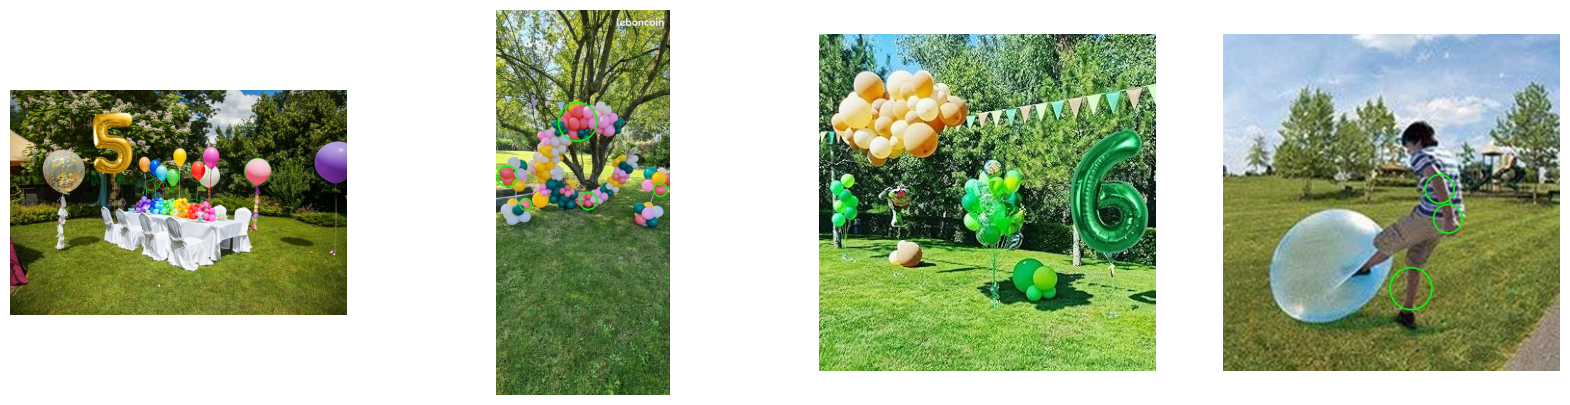

In [30]:
display_images("ballons\detections")


### Test baril bleu

In [ ]:
# range de couleurs pour baril bleu
lower_blue = np.array([100, 150, 50])    
upper_blue = np.array([130, 255, 255])

In [9]:
test_images = ["baril/baril_1.png", "baril/baril_2.jpg", "baril/baril_3.jpg"] 

test_color_form_detection(test_images, lower_blue, upper_blue,"rectangle","baril/detections",combined =False)

Pour baril/baril_1.png, 2 détections
Pour baril/baril_2.jpg, 1 détections
Pour baril/baril_3.jpg, 4 détections
Nombre total de ballons détectés : 7
Temps moyen de traitement par image : 0.0143 secondes


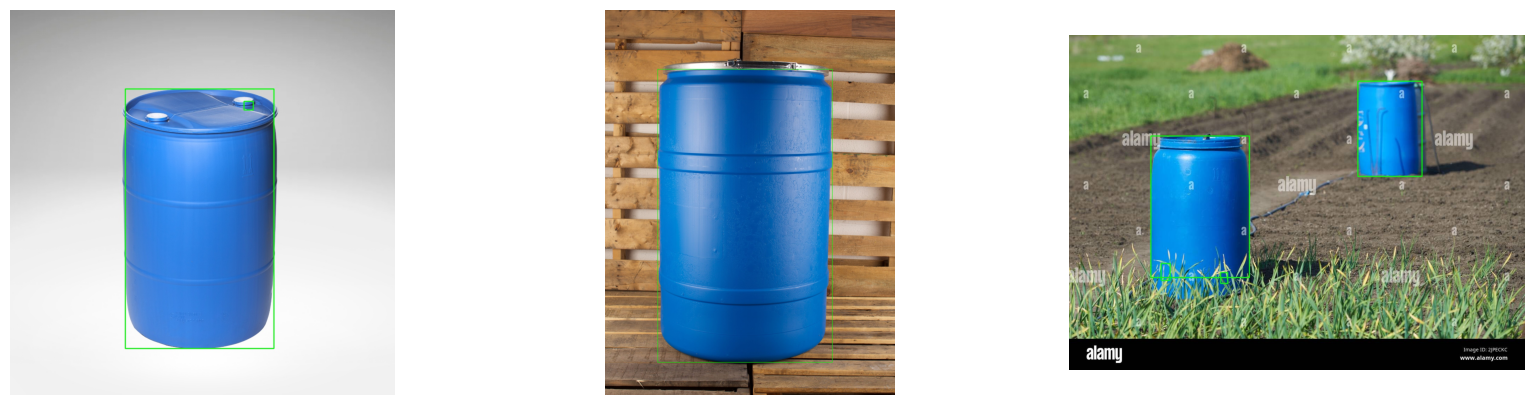

In [ ]:
display_images("baril\detections")

#### Notes : 

- difficulter à trouver les bons paramètres (exemple détection des jambes du garçon)